# Image labeller with persistence (example)

This notebook will demonstrate the follwing:

- using the image labelling tool as an IPython Notebook plugin
- rendering labels to create edge maps and label images
- extracting images of individual objects

It will also describe the label JSON file format.

In [1]:
%matplotlib inline

import os, math

from matplotlib import pyplot as plt

from IPython.display import display, Javascript

from image_labelling_tool import labelling_tool, labelling_tool_jupyter

/Users/geoff/packages/image-labelling-tool/image_labelling_tool/labelling_tool_jupyter.py:34: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode, Integer, List, Dict


## Example tool

The kernel-side widget model is defined in the `ImageLabellingTool` class in the `labelling_tool` module.

**Note**: the 'Loading...' screen may persist for a while initially; this is because the client-side tool is waiting for the notebook to finish executing all the cells below so it can get round to sending the label data to the client.

In [2]:
# Specify our 3 label classes.
# `LabelClass` parameters are: symbolic name, human readable name for UI, and colours by colour scheme.
    # The user can choose between colour schemes, this is useful when there are lots of label classes,
    # making it difficult to choose a range of colours that are easily differentiable from one another.
    # In this case, the colour schemes are 'default', 'natural' and 'artifical'.
    # They given human readable names that are displayed in the UI in the `tools.colour_schemes` section
    # of the `config` dictionary below.
label_classes = [
    labelling_tool.LabelClassGroup('Natural', [
        labelling_tool.LabelClass('tree', 'Trees', dict(default=[0, 255, 192], natural=[0, 255, 192],
                                                        artificial=[128, 128, 128])),
        labelling_tool.LabelClass('lake', 'Lake', dict(default=[0, 128, 255], natural=[0, 128, 255],
                                                       artificial=[128, 128, 128])),
    ]),
    labelling_tool.LabelClassGroup('Artificial', [
        labelling_tool.LabelClass('building', 'Buldings', dict(default=[255, 128, 0], natural=[128, 128, 128],
                                                               artificial=[255, 128, 0])),
    ])]

# Define the tool dimensions
TOOL_WIDTH, TOOL_HEIGHT = 980, 480

# Load in .JPG images from the 'images' directory.
labelled_images = labelling_tool.PersistentLabelledImage.for_directory('images', image_filename_pattern='*.jpg')
print('Loaded {0} images'.format(len(labelled_images)))

labelling_tool_config = {
    'tools': {
        'imageSelector': True,
        'labelClassSelector': True,
        'drawPolyLabel': True,
        'compositeLabel': True,
        'deleteLabel': True,
        'colour_schemes': [dict(name='default', human_name='All'),
                           dict(name='natural', human_name='Natural'),
                           dict(name='artificial', human_name='Artifical')],
    }
}

# Create the labelling tool IPython widget and display it
labeller = labelling_tool_jupyter.ImageLabellingTool(labelled_images=labelled_images, label_classes=label_classes,
                                                     tool_width=TOOL_WIDTH, tool_height=TOOL_HEIGHT,
                                                    labelling_tool_config=labelling_tool_config)

labeller

Loaded 2 images


ImageLabellingTool(images_=[{'image_id': '0', 'img_url': None, 'width': None, 'height': None}, {'image_id': '1…

### Instructions for use

To navigate between images:

- Using the left and right arrows to navigate the images one by one
- Enter a number in the box at the top to navigate to a specific image

To move around images:

- Left-click drag to move the image
- Use the scroll wheel (on a mouse) or a two-finger gesture (on a tablet) to zoom

To label regions of the image:

- **Drawing regions onto the image:**
  - Click the *Draw poly* button
  - Within the image pane, left-click to draw polygonal corners of your region
  - When you have finished the region, right-click to stop
  - You are still in *draw poly* mode, so you can start left-clicking again to draw the next region
  - To exit *draw poly* mode, right-click a second time.
  - If you make a mistake, delete the region and re-draw it; see below
- **Selecting regions:**
  - Selected regions have a red outline, yellow otherwise
  - If only *one* region is selected, clicking the *Draw poly* button will allow you to modify it; you will go back to *draw poly* mode
  - To select a different region, click the *Select* button and choose a different region by clicking on it. Multiple regions can be selected by holding *SHIFT* while clicking.
- **Deleting regions:**
  - Select regions using the select tool (see above)
  - Click the wastebin button to delete them; you will be asked for confirmation
- **Changing the label of a region:**
  - Select regions using the select tool (see above)
  - Use the drop-down (normally reads *UNCLASSIFIED*) within the *Labels* section to change the label
- **If the coloured regions are obscuring parts of the image that you need to see:**
  - Within the *Labels* section, click the *Hide labels* checkbox to hide the labels
  - Uncheck it to show them afterwards
- **When you are done:**
  - When you are satisfied that you have marked out all of the regions of interest and that they are correctly labelled, click the *Finished* checkbox within the *Current image* section. This will mark the image as finished within the system.

## Using the label data

You can either render the labels with the provided code or read the JSON label data directly.

### Render the labels

First, get the image 'uea_grounds_2.jpg' that comes with some labels pre-defined:

In [3]:
for limg in labelled_images:
    if os.path.basename(limg.image_path).lower() == 'uea_grounds_2.jpg':
        labelled_img = limg
        
print(labelled_img.image_path)

print(type(labelled_img))

images/uea_grounds_2.jpg
<class 'image_labelling_tool.labelling_tool.PersistentLabelledImage'>


#### Types

`labelled_images` is a list of `PersistentLabelledImage` instances. `PersistentLabelledImage` derives from `AbsractLabelledImage`. These classes pair images with corresponding labels. `PersistentLabelledImage` transparently loads an image when accessing its pixel content and loads or save labels when they accessed or modified.

Labels are represented by the `ImageLabels` class that directly represents the labels in vector form and provides methods to work with them.

#### Get a histogram of the label classes used

We can start by getting a histogram of the classes used. The `label_class_histogram` method is defined on the `ImageLabels` class. The `AbsractLabelledImage` class wraps it:

In [4]:
labelled_img.label_class_histogram()

{'building': 1, 'tree': 10, 'lake': 9}

#### Creating a semantic segmentation map

We can create a semantic segmentation map with the `render_labels` method.

As seen in the *Example Tool* cell above we have three classes; `tree`, `building` and `lake`.

The `label_classes` parameter describes the classes to render. We can choose a subset of labels to render. Label classes not listed in `label_classes` will be ignored. For example, lets render all the labels trees:

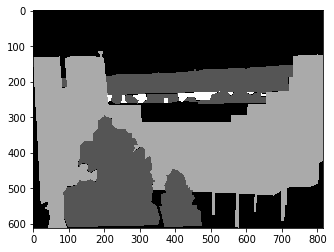

In [5]:
labels_2d = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Re-ordering changes the label values:

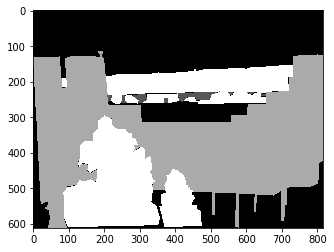

In [6]:
labels_2d = labelled_img.render_labels(label_classes=['lake', 'building', 'tree'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

You can render a subset of the labels used in the image; just the trees:

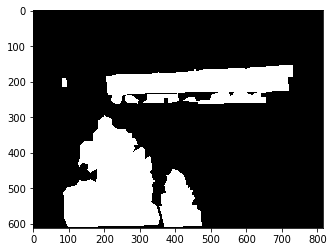

In [7]:
labels_2d = labelled_img.render_labels(['tree'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Each item in `label_classes` can also be a list of classes. This will result in the same value being used for multiple classes in the image. Lets render the natural featues - lake and trees - as one value and the non-natural - buildings - as another:

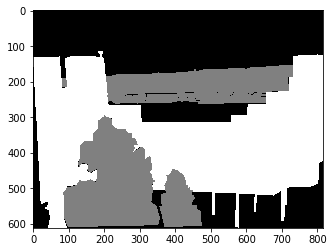

In [8]:
labels_2d = labelled_img.render_labels(label_classes=[['tree', 'lake'], 'building'], pixels_as_vectors=False)
plt.imshow(labels_2d, cmap='gray')
plt.show()

Setting the `fill` parameter to `False` results in outlines being rendered:

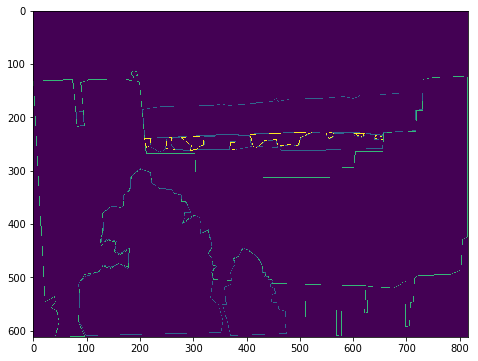

In [9]:
labels_2d = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=False, fill=False)
plt.figure(figsize=(8,6))
plt.imshow(labels_2d)
plt.show()

Setting the `pixels_as_vectors` parameter to `True` will result in a multi-channel image in the form of a 3D array. It will have one channel for each item in `label_classes`. Pixels will have either a value of `0` or `1` in a given channel indicating presence of a label in that class:

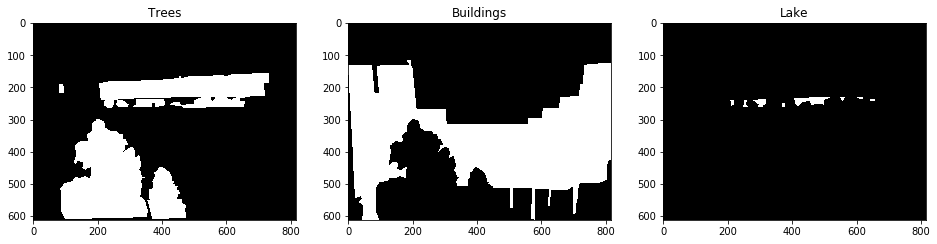

In [10]:
labels_2dn = labelled_img.render_labels(label_classes=['tree', 'building', 'lake'], pixels_as_vectors=True)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.title('Trees')
plt.imshow(labels_2dn[:,:,0], cmap='gray')

plt.subplot(1,3,2)
plt.title('Buildings')
plt.imshow(labels_2dn[:,:,1], cmap='gray')

plt.subplot(1,3,3)
plt.title('Lake')
plt.imshow(labels_2dn[:,:,2], cmap='gray')
plt.show()

#### Rendering individual labels

The `render_individual_labels` method assigns a different label value to each individual object. It returns a tuple of two values; the first is a label image as a 2D array where each pixel gives the index of the label and the second is a 1D array that gives the class index of each label. The `label_classes` parameter functions as with the `render_labels` method.

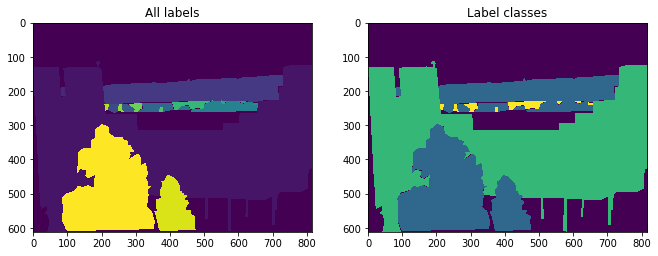

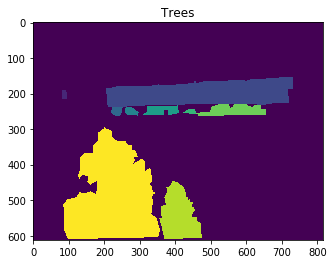

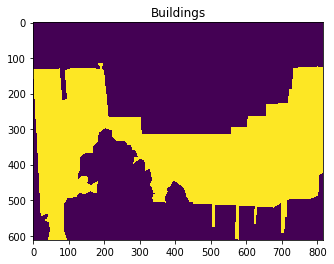

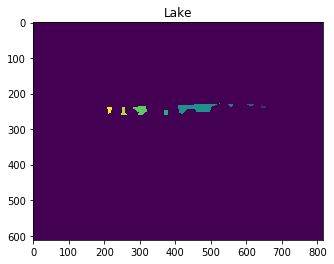

In [11]:
labels_2d, label_cls = labelled_img.render_individual_labels(label_classes=['tree', 'building', 'lake'])
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('Label classes')
plt.imshow(label_cls[labels_2d])
plt.show()

# trees
labels_2d, label_cls = labelled_img.render_individual_labels(label_classes=['tree'])
plt.figure()
plt.title('Trees')
plt.imshow(labels_2d)
plt.show()
# buildings
labels_2d, label_cls = labelled_img.render_individual_labels(label_classes=['building'])
plt.figure()
plt.title('Buildings')
plt.imshow(labels_2d)
plt.show()
# lake
labels_2d, label_cls = labelled_img.render_individual_labels(label_classes=['lake'])
plt.figure()
plt.title('Lake')
plt.imshow(labels_2d)
plt.show()


Setting the `fill` parameter to `False` results in an outline image as before:

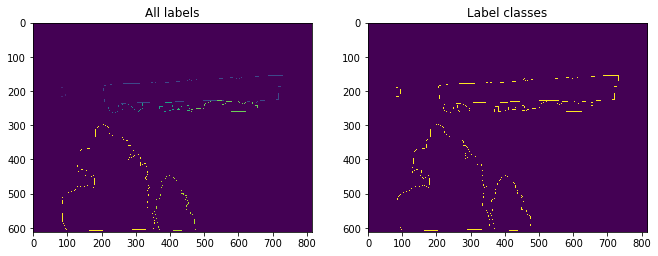

In [12]:
# Only render trees so that we can show one large image, otherwise the 1-pixel-wide outlines
# will be difficult to see:
labels_2d, label_cls = labelled_img.render_individual_labels(label_classes=['tree'], fill=False)
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title('All labels')
plt.imshow(labels_2d)

plt.subplot(1, 2, 2)
plt.title('Label classes')
plt.imshow(label_cls[labels_2d])
plt.show()


#### Extracting images of labelled objects

The `extract_label_images` method extracts the pixels covered by each individual labelled object from the original image. The `label_class_set` parameter specifies the classes of objects that should be rendered; objects whoses classes are not listed are not rendered. It can also be `None` to render all objects of all classes. It returns a list of images:

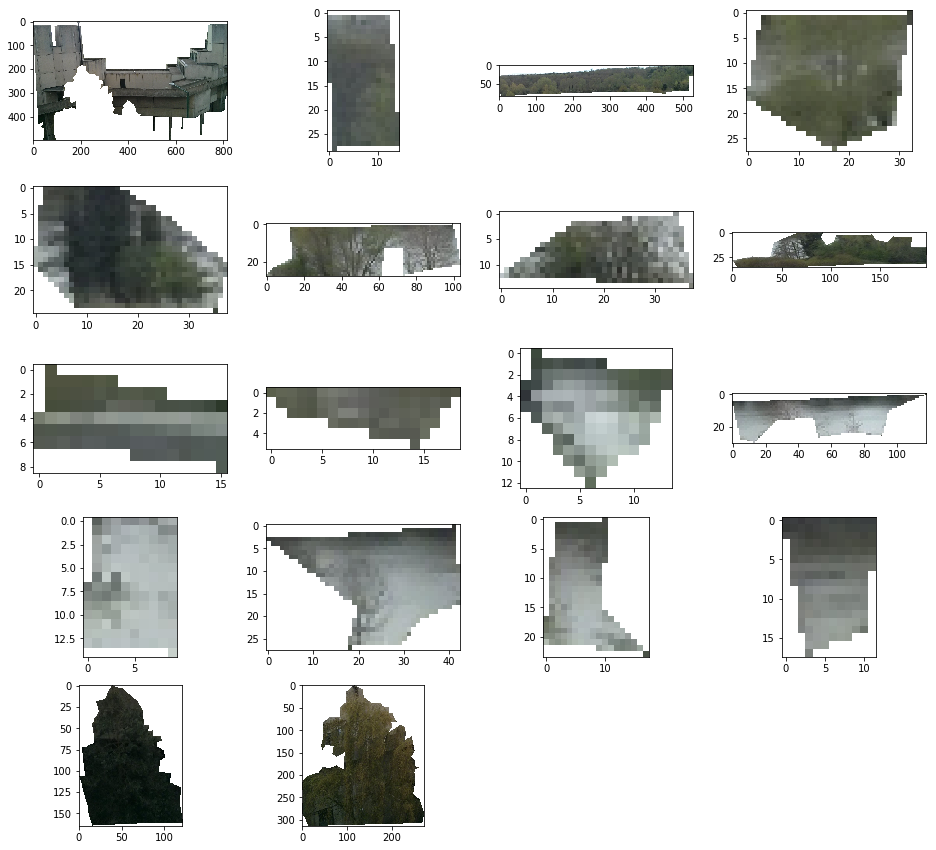

In [13]:
# Render all objects:
object_images = labelled_img.extract_label_images(label_class_set=None)
n_cols = 4
n_rows = int(math.ceil(float(len(object_images)) / n_cols))
plt.figure(figsize=(16,n_rows*3))
    
for i, img in enumerate(object_images):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
plt.show()

Extract objects separately by class:

Extracted objects of class 'tree':


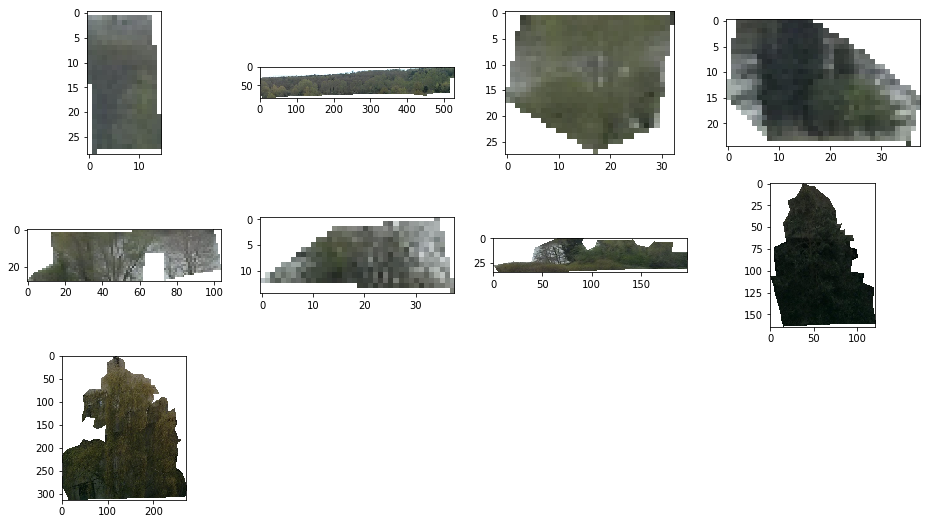

Extracted objects of class 'lake':


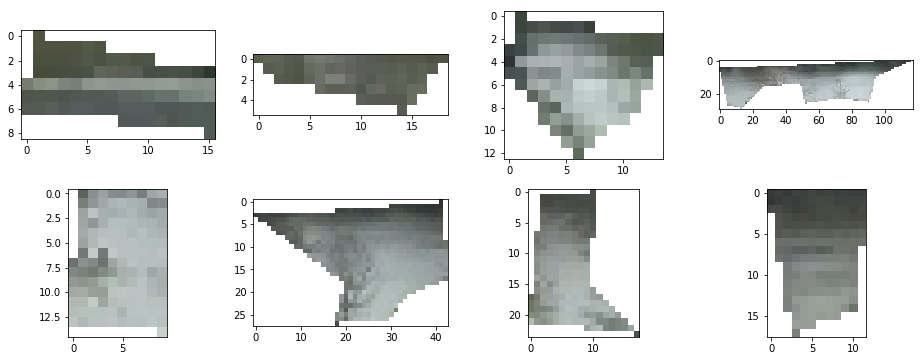

Extracted objects of class 'building':


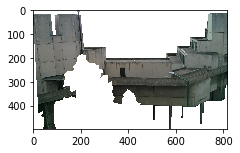

In [14]:
for cls in ['tree', 'lake', 'building']:
    print('Extracted objects of class \'{0}\':'.format(cls))
    object_images = labelled_img.extract_label_images(label_class_set=[cls])
    n_cols = 4
    n_rows = int(math.ceil(float(len(object_images)) / n_cols))
    plt.figure(figsize=(16,n_rows*3))

    for i, img in enumerate(object_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
    plt.show()

### Label data API

The label data access API will now be demonstrated.

First, load the labels from the JSON file:

In [15]:
labels_path = os.path.join('images', 'uea_grounds_2__labels.json')
labels = labelling_tool.ImageLabels.from_file(labels_path)

Show the first label:

In [16]:
print('len(labels)={}'.format(len(labels)))
print('type(labels[0])={}'.format(type(labels[0])))
print('labels[0].object_id={}'.format(labels[0].object_id))
print('labels[0].classification={}'.format(labels[0].classification))
print('labels[0].vertices={}'.format(labels[0].vertices))
print('labels[0]={}'.format(labels[0]))

len(labels)=20
type(labels[0])=<class 'image_labelling_tool.labelling_tool.PolygonLabel'>
labels[0].object_id=1
labels[0].classification=building
labels[0].vertices=[[2.31944025e-01 1.32071304e+02]
 [7.46640167e+01 1.30330200e+02]
 [8.29342499e+01 2.18255814e+02]
 [9.64277802e+01 2.16949982e+02]
 [8.90281067e+01 1.35553497e+02]
 [1.05133286e+02 1.30765472e+02]
 [1.70424576e+02 1.29894928e+02]
 [1.89576691e+02 1.32506577e+02]
 [1.88706146e+02 1.23801071e+02]
 [1.85223938e+02 1.22495247e+02]
 [1.83482849e+02 1.16401390e+02]
 [1.89141418e+02 1.14225014e+02]
 [1.95670547e+02 1.15530838e+02]
 [1.96541107e+02 1.22930519e+02]
 [1.93058899e+02 1.22930519e+02]
 [1.93929443e+02 1.32941849e+02]
 [1.99152756e+02 1.34682953e+02]
 [2.12646286e+02 2.68312469e+02]
 [2.38624527e+02 2.68581879e+02]
 [2.80264832e+02 2.68294708e+02]
 [3.03525970e+02 2.68869049e+02]
 [3.05853027e+02 3.14466400e+02]
 [5.57787537e+02 3.13127136e+02]
 [5.57787537e+02 2.95609497e+02]
 [6.02873962e+02 2.94747986e+02]
 [6.045969

### JSON Label Format

The label data is in JSON form. An example file is included in the `images` directory. The format of the file will now be described.

```
<root>: 

{
    image_filename: <image filename as string>,
    complete: <boolean indicating if the user has marked the labels as complete>
    labels: [
        <label_object 0>,
        <label_object 1>,
        ...
        <label_object N>
    ]
}


<label_object -- where label_type=polygon>:
{
    label_class: <label class as string; identifiers used above to identify label classes>
    label_type: 'polygon',
    vertices: [
        <vector2 0>,
        <vector2 1>,
        ...
        <vector2 N>
    ]
}


<vector2>:
{
    x: <x-co-ordinate as float>,
    y: <y-co-ordinate as float>
}
```
